# Faster R-CNN in PyTorch (inbuilt torchvision model)

This notebook fine-tunes torchvision's inbuilt Faster R-CNN (ResNet-50 FPN v2) on the PennFudan Pedestrian dataset.

What it does:
- Downloads and prepares PennFudan (boxes derived from masks)
- Builds DataLoaders with a detection-friendly collate
- Uses `torchvision.models.detection.fasterrcnn_resnet50_fpn_v2`
- Replaces the predictor for 2 classes (background + person)
- Trains, saves a checkpoint, and runs inference + visualization

Notes:
- Images are tensors in [0,1]. Faster R-CNN handles normalization/resizing internally.
- On CPU, keep epochs small; GPU recommended for speed.

In [2]:
# Install dependencies if missing
import sys, subprocess

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

try:
    import torch, torchvision  # noqa: F401
except Exception:
    print("Installing torch/torchvision (CPU wheels). For GPU, prefer a runtime with CUDA preinstalled.")
    pip_install(["torch", "torchvision", "torchaudio"])  

try:
    import matplotlib  # noqa: F401
except Exception:
    pip_install(["matplotlib"])  

try:
    import tqdm  # noqa: F401
except Exception:
    pip_install(["tqdm"])  

In [3]:
import os
import time
import zipfile
import random
import urllib.request
from pathlib import Path
from typing import Dict, Any

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True

Using device: cuda


## Download and prepare PennFudanPed
We derive bounding boxes from the instance masks. Single class: person (label=1). Background=0, so `num_classes=2`.

In [4]:
DATA_ROOT = Path("/kaggle/working")
PENNFUDAN_URL = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
PENNFUDAN_DIR = DATA_ROOT / "PennFudanPed"

def download_pennfudan():
    PENNFUDAN_DIR.parent.mkdir(parents=True, exist_ok=True)
    if PENNFUDAN_DIR.exists():
        print("PennFudan already present.")
        return
    zip_path = DATA_ROOT / "PennFudanPed.zip"
    if not zip_path.exists():
        print("Downloading PennFudanPed...")
        urllib.request.urlretrieve(PENNFUDAN_URL, zip_path)
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(DATA_ROOT)
    print("Done.")

download_pennfudan()

class PennFudanDataset(Dataset):
    def __init__(self, root: Path, train: bool = True, transforms=None):
        self.root = Path(root)
        self.imgs = sorted((self.root / "PNGImages").glob("*.png"))
        self.masks = sorted((self.root / "PedMasks").glob("*.png"))
        assert len(self.imgs) == len(self.masks)
        self.train = train
        if transforms is None:
            self.transforms = T.Compose([T.PILToTensor(), T.ConvertImageDtype(torch.float32)])  # [0,1]
        else:
            self.transforms = transforms

    def __len__(self):
        return len(self.imgs)

    def _random_hflip(self, image: torch.Tensor, boxes: torch.Tensor, p: float = 0.5):
        if not self.train or random.random() > p:
            return image, boxes
        _, H, W = image.shape
        image = torch.flip(image, dims=[2])  # horizontal flip
        if boxes.numel():
            x1 = boxes[:, 0].clone()
            x2 = boxes[:, 2].clone()
            boxes[:, 0] = W - x2
            boxes[:, 2] = W - x1
        return image, boxes

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask_np = np.array(mask)
        obj_ids = np.unique(mask_np)[1:]  # remove background 0

        boxes = []
        for oid in obj_ids:
            pos = np.where(mask_np == oid)
            if pos[0].size == 0 or pos[1].size == 0:
                continue
            y1 = np.min(pos[0]); y2 = np.max(pos[0])
            x1 = np.min(pos[1]); x2 = np.max(pos[1])
            if (x2 - x1) >= 4 and (y2 - y1) >= 4:
                boxes.append([x1, y1, x2, y2])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # single class: person=1

        img_t = self.transforms(img)
        img_t, boxes = self._random_hflip(img_t, boxes, p=0.5)

        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) if boxes.numel() else torch.as_tensor([], dtype=torch.float32)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx], dtype=torch.int64),
            'area': area,
            'iscrowd': iscrowd,
        }
        return img_t, target, img  # include PIL for visualization later

full_dataset = PennFudanDataset(PENNFUDAN_DIR, train=True)
print("Total images:", len(full_dataset))

# Train/test split
indices = list(range(len(full_dataset)))
random.shuffle(indices)
split = int(0.8 * len(indices))
train_indices, test_indices = indices[:split], indices[split:]

class SubsetWrap(Dataset):
    def __init__(self, base, indices, train=True):
        self.base = base
        self.indices = indices
        self.train = train
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, i):
        prev = self.base.train
        self.base.train = self.train
        out = self.base[self.indices[i]]
        self.base.train = prev
        return out

train_ds = SubsetWrap(full_dataset, train_indices, train=True)
test_ds  = SubsetWrap(full_dataset, test_indices, train=False)
print("Train:", len(train_ds), " Test:", len(test_ds))

Extracting...
Done.
Total images: 170
Train: 136  Test: 34


## DataLoaders and collate function
Detection models need a custom collate that returns lists of images and targets.

In [5]:
def collate_fn(batch):
    images, targets, pil_imgs = list(zip(*batch))
    return list(images), list(targets), list(pil_imgs)

batch_size = 2 if device.type == 'cuda' else 1
num_workers = 2 if device.type == 'cuda' else 0

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

## Build the inbuilt Faster R-CNN model
- Start from pretrained weights (v2)
- Replace the predictor for 2 classes (background + person)
- Train all parameters (optionally freeze backbone)

In [6]:
num_classes = 2  # background + person

def get_model(num_classes: int):
    try:
        weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
        model = fasterrcnn_resnet50_fpn_v2(weights=weights)
    except Exception as e:
        print("Falling back to no pretrained weights due to:", e)
        model = fasterrcnn_resnet50_fpn_v2(weights=None)
    # Replace the classifier for our dataset
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = get_model(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Model ready. Trainable parameters:", sum(p.numel() for p in params))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 216MB/s] 


Model ready. Trainable parameters: 43030809


## Training loop
The inbuilt detection model returns a dict of losses in training mode. We sum and backpropagate.

In [8]:
def train_one_epoch(epoch: int):
    model.train()
    running_loss = 0.0
    steps = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (images, targets, _) in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
        steps += 1
        pbar.set_description(f"Epoch {epoch} | loss {losses.item():.3f}")
    return running_loss / max(steps, 1)

EPOCHS = 15  # Increase for better results (e.g., 10–15 on GPU)
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    avg_loss = train_one_epoch(epoch)
    lr_scheduler.step()
    print(f"Epoch {epoch} done in {time.time() - t0:.1f}s | avg loss {avg_loss:.4f}")

# Save checkpoint
ckpt_path = Path("./faster_rcnn_pennfudan.pth")
torch.save({ 'model': model.state_dict(), 'num_classes': num_classes }, ckpt_path)
print("Saved checkpoint to", ckpt_path.resolve())

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 1 done in 430.6s | avg loss 0.1088


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 2 done in 297.6s | avg loss 0.0667


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 3 done in 173.0s | avg loss 0.0618


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 4 done in 162.7s | avg loss 0.0531


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 5 done in 146.2s | avg loss 0.0446


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 6 done in 120.1s | avg loss 0.0359


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 7 done in 134.0s | avg loss 0.0364


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 8 done in 151.9s | avg loss 0.0323


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 9 done in 134.2s | avg loss 0.0370


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 10 done in 115.0s | avg loss 0.0301


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 11 done in 160.6s | avg loss 0.0311


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 12 done in 83.8s | avg loss 0.0304


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch 15 done in 84.1s | avg loss 0.0307
Saved checkpoint to /kaggle/working/faster_rcnn_pennfudan.pth


## Inference and visualization
The model performs its own postprocessing and NMS internally. We filter detections by a score threshold for display.

Image 0: 5 raw detections, showing score >= 0.6


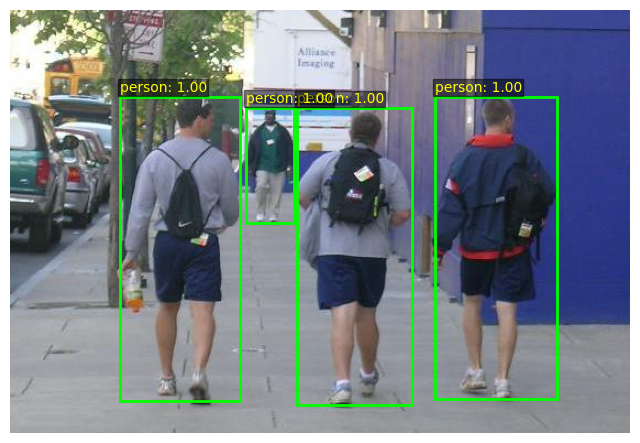

Image 1: 3 raw detections, showing score >= 0.6


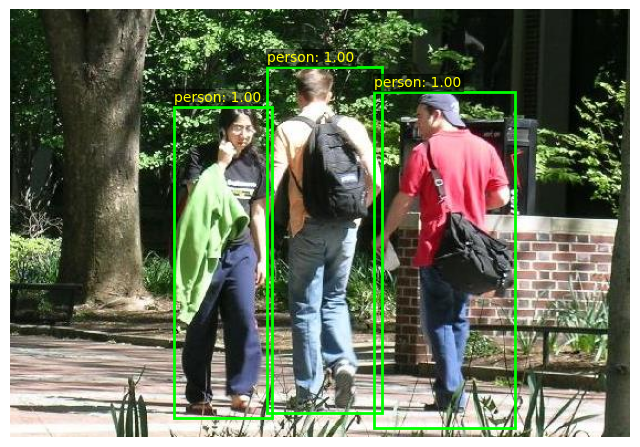

Image 2: 3 raw detections, showing score >= 0.6


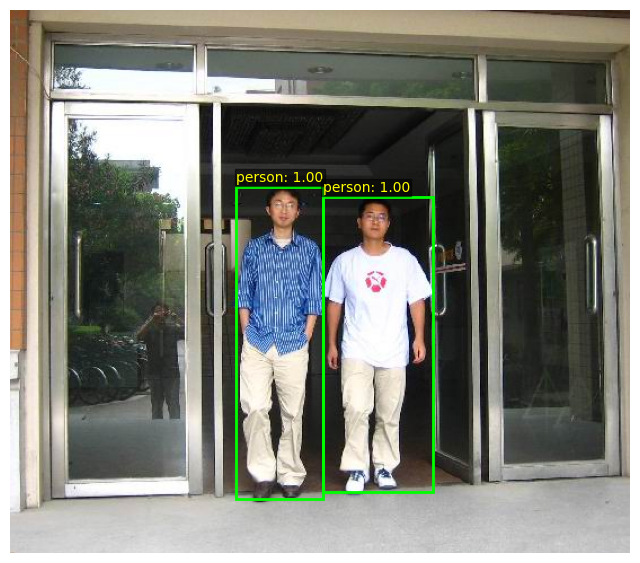

In [9]:
@torch.inference_mode()
def predict(image_tensor: torch.Tensor):
    model.eval()
    outputs = model([image_tensor.to(device)])
    return outputs[0]

def visualize_detections(pil_img: Image.Image, pred: Dict[str, Any], score_thresh: float = 0.5):
    boxes = pred['boxes'].detach().cpu().numpy()
    scores = pred['scores'].detach().cpu().numpy()
    labels = pred['labels'].detach().cpu().numpy()
    keep = scores >= score_thresh
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(pil_img)
    for box, sc, lab in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"person: {sc:.2f}", color='yellow', fontsize=10,
                bbox=dict(facecolor='black', alpha=0.5, pad=1))
    ax.axis('off')
    plt.show()

# Run on a few test samples
for i in range(min(3, len(test_ds))):
    img_t, target, pil_img = test_ds[i]
    pred = predict(img_t)
    print(f"Image {i}: {len(pred['boxes'])} raw detections, showing score >= 0.6")
    visualize_detections(pil_img, pred, score_thresh=0.6)

## Optional: reload checkpoint later
Run this cell to reload the saved weights.

In [ ]:
# Reload model from checkpoint (optional)
def load_model(ckpt_path: Path):
    ckpt = torch.load(ckpt_path, map_location=device)
    m = get_model(ckpt.get('num_classes', 2)).to(device)
    m.load_state_dict(ckpt['model'])
    m.eval()
    return m

_ = load_model(Path('./faster_rcnn_pennfudan.pth'))  # example usage